<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Single-label-classifier" data-toc-modified-id="Single-label-classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Single label classifier</a></span><ul class="toc-item"><li><span><a href="#Train-from-scratch" data-toc-modified-id="Train-from-scratch-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train from scratch</a></span></li><li><span><a href="#Pretrained-model" data-toc-modified-id="Pretrained-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pretrained model</a></span></li></ul></li><li><span><a href="#Single-label-classifier-using-singles-subset" data-toc-modified-id="Single-label-classifier-using-singles-subset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Single label classifier using singles subset</a></span><ul class="toc-item"><li><span><a href="#Train-from-scratch" data-toc-modified-id="Train-from-scratch-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train from scratch</a></span></li><li><span><a href="#Pretrained-model" data-toc-modified-id="Pretrained-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pretrained model</a></span></li></ul></li><li><span><a href="#Multi-label-classifier" data-toc-modified-id="Multi-label-classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Multi label classifier</a></span></li></ul></div>

# Single label classifier

In [ ]:
from fastai.vision.all import *


### Get files and annos ###
path = Path('/home/rory/data/coco2017')
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path,'annotations/instances_train2017.json', 'train2017')
valid_files, valid_annos = get_annos(path,'annotations/instances_val2017.json',   'val2017')
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]


### Process annos ###
def transpose(anno): return list(zip(*anno))
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = L(sort_annos(i) for i in annos)
largest_anno = L(i[0] for i in sorted_annos)
largest_bbox = L(i[0] for i in largest_anno)
largest_lbl  = L(i[1] for i in largest_anno)


### Datasets ###
files2lbls = {f:l for f,l in zip(files,largest_lbl)}
def get_lbl(x): return files2lbls[x]
splits = (L(range(len(train_files))),
          L(range(len(valid_files))).map(lambda x: x + len(train_files)))
dss_tfms = [[PILImage.create],[get_lbl, Categorize]]
dss = Datasets(files, tfms=dss_tfms, splits=splits)


### DataLoaders ###
cpu_tfms = [Resize(224, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize()]
dls = dss.dataloaders(bs=64, after_item=cpu_tfms, after_batch=gpu_tfms)


### Model ###
def convlayr(i, o): return ConvLayer(i, o, stride=2)
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf, nf, stride=1)
        self.conv2 = ConvLayer(nf, nf, stride=1)
    def forward(self, x): return x + self.conv2(self.conv1(x))
def conv_res(i,o): return nn.Sequential(convlayr(i,o), ResBlock(o))
p = 20
mod = nn.Sequential(
    conv_res(3  ,p*1),
    conv_res(p*1,p*2),
    conv_res(p*2,p*4),
    conv_res(p*4,p*2),
    convlayr(p*2,dls.c),
    Flatten())

## Train from scratch

In [ ]:
### Train ###
learn = Learner(dls, mod, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()
learn.fit_one_cycle(10, slice(lr_min/1000,lr_min))

KeyboardInterrupt: 

## Pretrained model

epoch,train_loss,valid_loss,accuracy,time
0,1.095382,0.950564,0.733643,02:45
1,0.941267,0.880089,0.751817,02:46


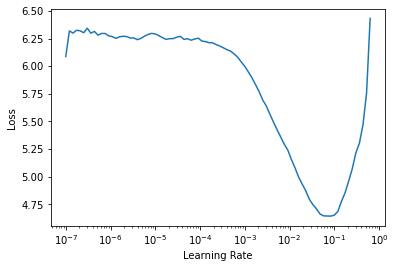

In [ ]:
### Model & Train ###
learn = cnn_learner(dls, resnet34, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()
learn.fit_one_cycle(2, lr=lr_min) # trained in 5min 43s; acc = .752

# Single label classifier using singles subset

In [ ]:
from fastai.vision.all import *


### Get files and annos ###
path = Path('/home/rory/data/coco2017')
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path,'annotations/instances_train2017.json', 'train2017')
valid_files, valid_annos = get_annos(path,'annotations/instances_val2017.json',   'val2017')
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]
# mappings
files2lbls = {f:l for f,l in zip(files,largest_lbl)}
def get_lbl(x): return files2lbls[x]


### Process annos ###
def transpose(anno): return list(zip(*anno))
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = L(sort_annos(i) for i in annos)
largest_anno = L(i[0] for i in sorted_annos)
largest_bbox = L(i[0] for i in largest_anno)
largest_lbl  = L(i[1] for i in largest_anno)


### Get singles ###
# identify singles
zipped = L(zip(files, largest_lbl))
lbls_per_im = L(len(l) for l in lbls)
singles = zipped[lbls_per_im.map(lambda n:n==1)]

# identify lbls with at least 500 singles
singles2lbl = {p:l for p,l in singles}
transposed = list(zip(*singles))
lbl2paths = {l:[p for p in transposed[0] if get_lbl(p) == l] 
             for l in set(transposed[1])}
lbl_subset = []
for lbl in lbl2paths:
    l = len(lbl2paths[lbl])
    if l > 500: lbl_subset += [lbl]
        
# create subset of ims in lbl_subset
zipped_subset = L(s for s in singles if s[1] in lbl_subset)
files_subset = L(i[0] for i in zipped_subset)


### Datasets ###
subset2lbl = {f:l for f,l in zipped_subset}
def get_subset_lbl(x): return subset2lbl[x]
splits = RandomSplitter(.1)(files_subset)
dss_tfms = [[PILImage.create],[get_subset_lbl, Categorize]]
dss = Datasets(files_subset, tfms=dss_tfms, splits=splits)


### DataLoaders ###
cpu_tfms = [Resize(224, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize()]
dls = dss.dataloaders(bs=64, after_item=cpu_tfms, after_batch=gpu_tfms)


### Model ###
def convlayr(i, o): return ConvLayer(i, o, stride=2)
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf, nf, stride=1)
        self.conv2 = ConvLayer(nf, nf, stride=1)
    def forward(self, x): return x + self.conv2(self.conv1(x))
def conv_res(i,o): return nn.Sequential(convlayr(i,o), ResBlock(o))
p = 20
mod = nn.Sequential(
    conv_res(3  ,p*1),
    conv_res(p*1,p*2),
    conv_res(p*2,p*4),
    conv_res(p*4,p*2),
    convlayr(p*2,dls.c),
    Flatten())

## Train from scratch

epoch,train_loss,valid_loss,accuracy,time
0,2.193507,2.029583,0.246715,00:08
1,1.991667,2.030008,0.223358,00:08
2,1.934325,1.966369,0.268613,00:08
3,1.848201,1.835181,0.315328,00:08


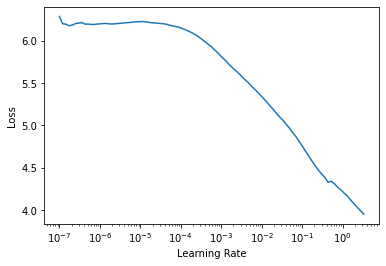

In [ ]:
### Train ###
learn = Learner(dls, mod, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()
learn.fit_one_cycle(4, slice(lr_min/1000,lr_min)) # trained in 1min 10s; acc = .315

## Pretrained model

epoch,train_loss,valid_loss,accuracy,time
0,0.470554,0.148162,0.957664,00:11
1,0.175182,0.129435,0.964963,00:11


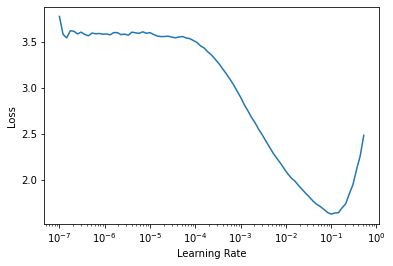

In [ ]:
### Model & Train ###
learn = cnn_learner(dls, resnet34, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()
learn.fit_one_cycle(2, lr=lr_min) # trained in 32s; acc = .966

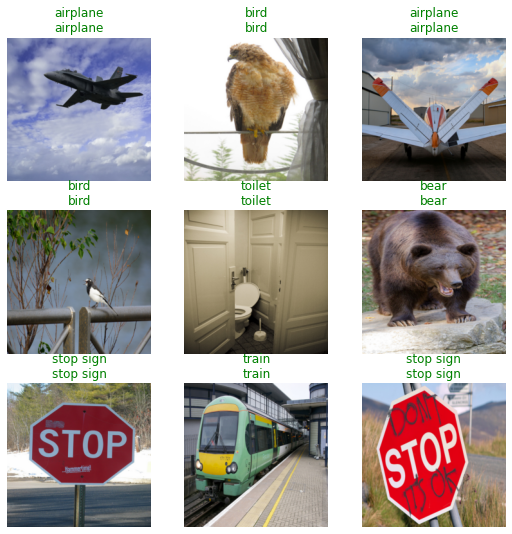

In [ ]:
learn.show_results()

# Multi label classifier

In [ ]:
from fastai.vision.all import *

In [ ]:
### Get files and annos ###
path = Path('/home/rory/data/coco2017')
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path,'annotations/instances_train2017.json', 'train2017')
valid_files, valid_annos = get_annos(path,'annotations/instances_val2017.json',   'val2017')
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]

In [ ]:
### Process annos ###
def transpose(anno): return list(zip(*anno))
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = L(sort_annos(i) for i in annos)
largest_anno = L(i[0] for i in sorted_annos)
largest_bbox = L(i[0] for i in largest_anno)
largest_lbl  = L(i[1] for i in largest_anno)

In [ ]:
### Datasets ###
files2lbls = {f:l for f,l in zip(files,lbls)}
def get_lbl(x): return files2lbls[x]
splits = (L(range(len(train_files))),
          L(range(len(valid_files))).map(lambda x: x + len(train_files)))
dss_tfms = [[PILImage.create],[get_lbl, MultiCategorize]]
dss = Datasets(files, tfms=dss_tfms, splits=splits)

In [ ]:
dss.train[1]

(PILImage mode=RGB size=640x480, TensorMultiCategory([49, 41, 17, 57]))

In [ ]:
dss.train[3]

(PILImage mode=RGB size=556x640,
 TensorMultiCategory([49, 49, 45, 45, 39, 39, 45, 75, 75, 75, 45]))

Those two category tensors are different sizes. I'll need to figure out how to 1HE them – should be an example somewhere :) .

In [ ]:
# debugging this – a lead on the issue is noted above.
### DataLoaders ###
cpu_tfms = [Resize(224, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize()]
dls = dss.dataloaders(bs=64, after_item=cpu_tfms, after_batch=gpu_tfms)

RuntimeError: stack expects each tensor to be equal size, but got [9] at entry 0 and [19] at entry 1

In [ ]:
# didn't get to this
### Model & Train ###
learn = cnn_learner(dls, resnet34, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()
learn.fit_one_cycle(2, lr=lr_min) # trained in 5min 43s; acc = .752